In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:
/tmp/ipykernel_20/3214691180.py:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling

In [3]:
# read train.csv
df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')

# Overview the training set

In [4]:
# the first five rows of the train set
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
# get column types
column_types = df.dtypes
# get number of values per column
num_values = df.count()
# get number of missing values per column
num_missing = df.isnull().sum()
# cardinality of features
unique_type = df.select_dtypes(include="object").nunique()
# create a summary table
summary_table = pd.DataFrame({'Column Type': column_types,
                              'Number of Values': num_values,
                              'Number of Missing Values': num_missing,
                              'Cardinality': unique_type,
                             })
summary_table

,Column Type,Number of Values,Number of Missing Values,Cardinality
Age,float64,8514,179,NaN
Cabin,object,8494,199,6560.0
CryoSleep,object,8476,217,2.0
Destination,object,8511,182,3.0
FoodCourt,float64,8510,183,NaN
HomePlanet,object,8492,201,3.0
Name,object,8493,200,8473.0
PassengerId,object,8693,0,8693.0
RoomService,float64,8512,181,NaN
ShoppingMall,float64,8485,208,NaN


In [6]:
print(f'Number of rows in train set: {df.shape[0]}')
print(f'Number of columns in train set: {df.shape[1]}')
print(f'Number of values in train set: {df.count().sum()}')
print(f'Number missing values in train set: {sum(df.isnull().sum())}')

Number of rows in train set: 8693
Number of columns in train set: 14
Number of values in train set: 119378
Number missing values in train set: 2324


# Without imputation (the categorical column fills the missing data with "Missing")

## Split the Cabin

In [7]:
# split the cabin in three column
def split_cabin_and_fill_missing(x):
    # cabin is not missing
    if(len(str(x).split('/')) == 3):
        return str(x).split('/')
    else:
        return ['Missing', 'Missing', 'Missing']

In [8]:
def preprocessing(df):
    # HomePlanet - fill missing data with 'Missing'
    df['HomePlanet'].fillna('Missing', inplace=True)
    
    # CryoSleep - drop
    df['CryoSleep'].fillna('Missing', inplace=True)
    
    # Cabin - extract the deck and side to create new column 'Cabin_deck' and 'Cabin_side'
    df['Cabin_deck'] = df['Cabin'].apply(lambda x: split_cabin_and_fill_missing(x)[0])
    df['Cabin_side'] = df['Cabin'].apply(lambda x: split_cabin_and_fill_missing(x)[2])
    df.drop('Cabin', axis=1, inplace=True)
    
    # Destination - fill missing data with 'Missing'
    df['Destination'].fillna('Missing', inplace=True)
    
    # Age - fill missing data the mean of the age
    age_mean = df["Age"].mean()
    df['Age'].fillna(age_mean, inplace=True)
    
    # VIP - imbalance column
    # the majority is false, so fill false
    df['VIP'].fillna(False, inplace=True)
    
    # RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
    # most of the distribution is 0, so just fill 0 for the missing data
    df['RoomService'].fillna(0, inplace=True)
    df['FoodCourt'].fillna(0, inplace=True)
    df['ShoppingMall'].fillna(0, inplace=True)
    df['Spa'].fillna(0, inplace=True)
    df['VRDeck'].fillna(0, inplace=True)
    
    # Name - drop due to high cardinality
    df.drop('Name', axis=1, inplace=True)

# Preprocessing dataset 1

In [9]:
# abt_1 = df.copy()
# preprocessing(abt_1)

# abt_1.head()

# EDA

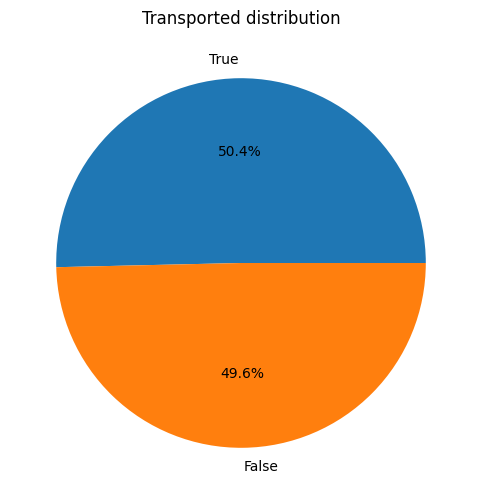

In [10]:
# calculate the frequency of each category
transported_data = df['Transported'].value_counts()

# create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(transported_data, labels=transported_data.index, autopct='%1.1f%%')
plt.title('Transported distribution')
plt.show()

## Visualizing Age features

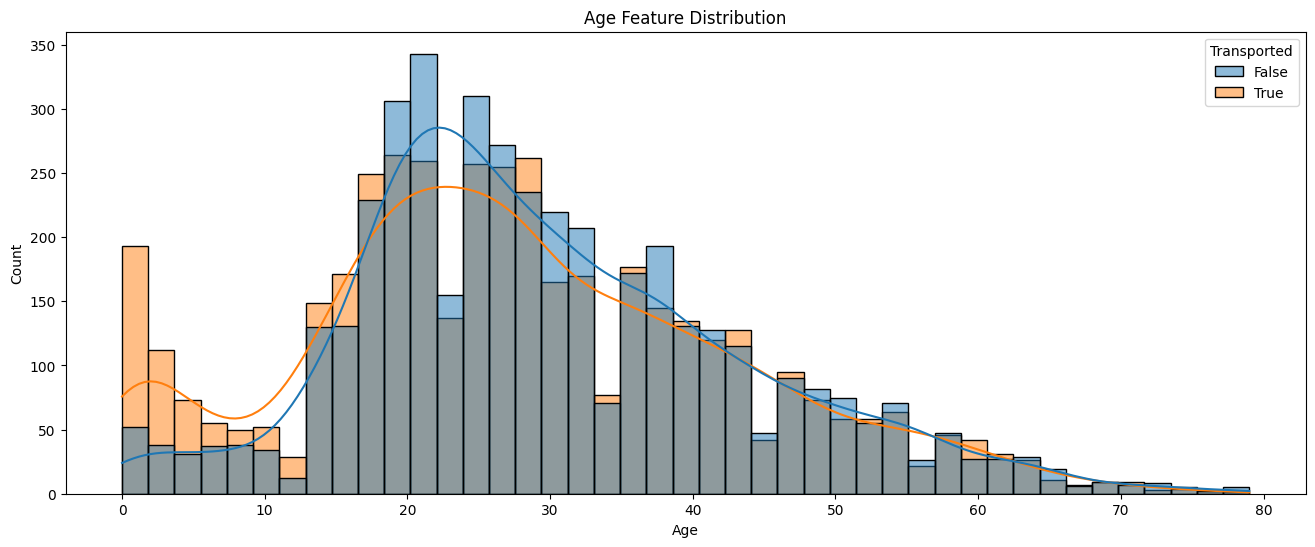

In [11]:
# Age normal distribution graph
plt.figure(figsize=(16,6))
sns.histplot(x=df["Age"],hue="Transported",data=df,kde=True)
plt.title("Age Feature Distribution");

## Visualizing all expenditure features

/tmp/ipykernel_20/153166312.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_20/153166312.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_20/153166312.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_20/153166312.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


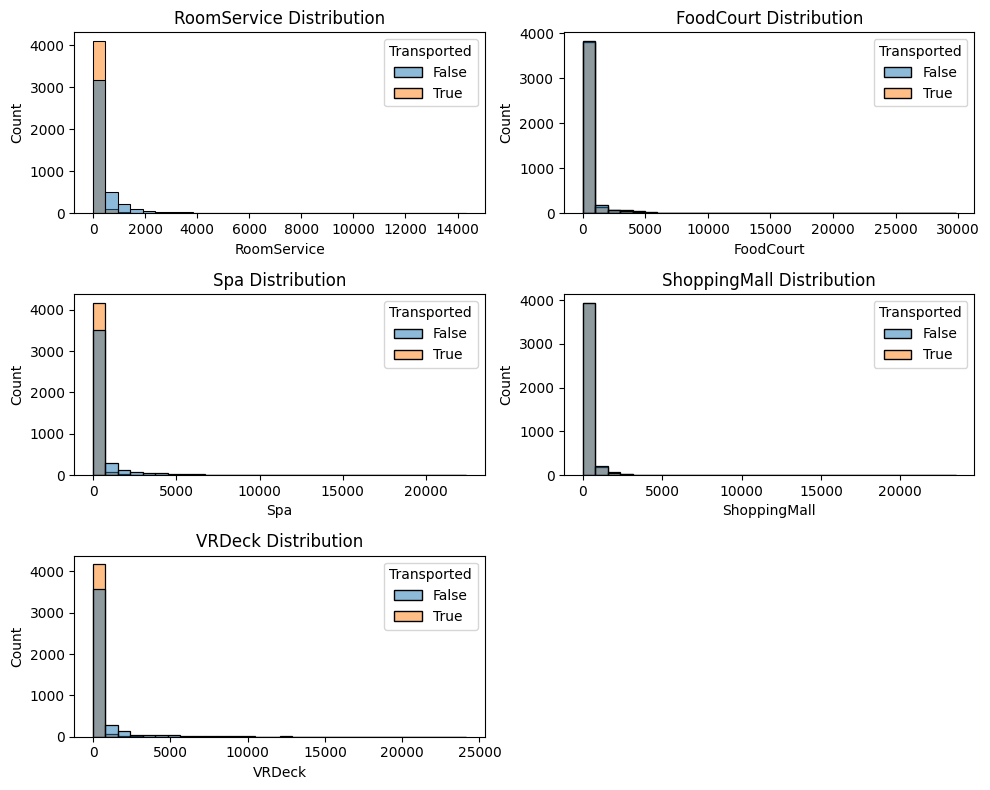

In [12]:
exp_cols = ["RoomService","FoodCourt", "Spa", "ShoppingMall","VRDeck"]

plt.figure(figsize=(10,8))
for idx,column in enumerate(exp_cols):
    plt.subplot(3,2,idx+1)
    sns.histplot(x=column, hue="Transported", data=df, bins=30, kde=False)
    plt.title(f"{column} Distribution")
    plt.tight_layout()

## Visualizing categorical features

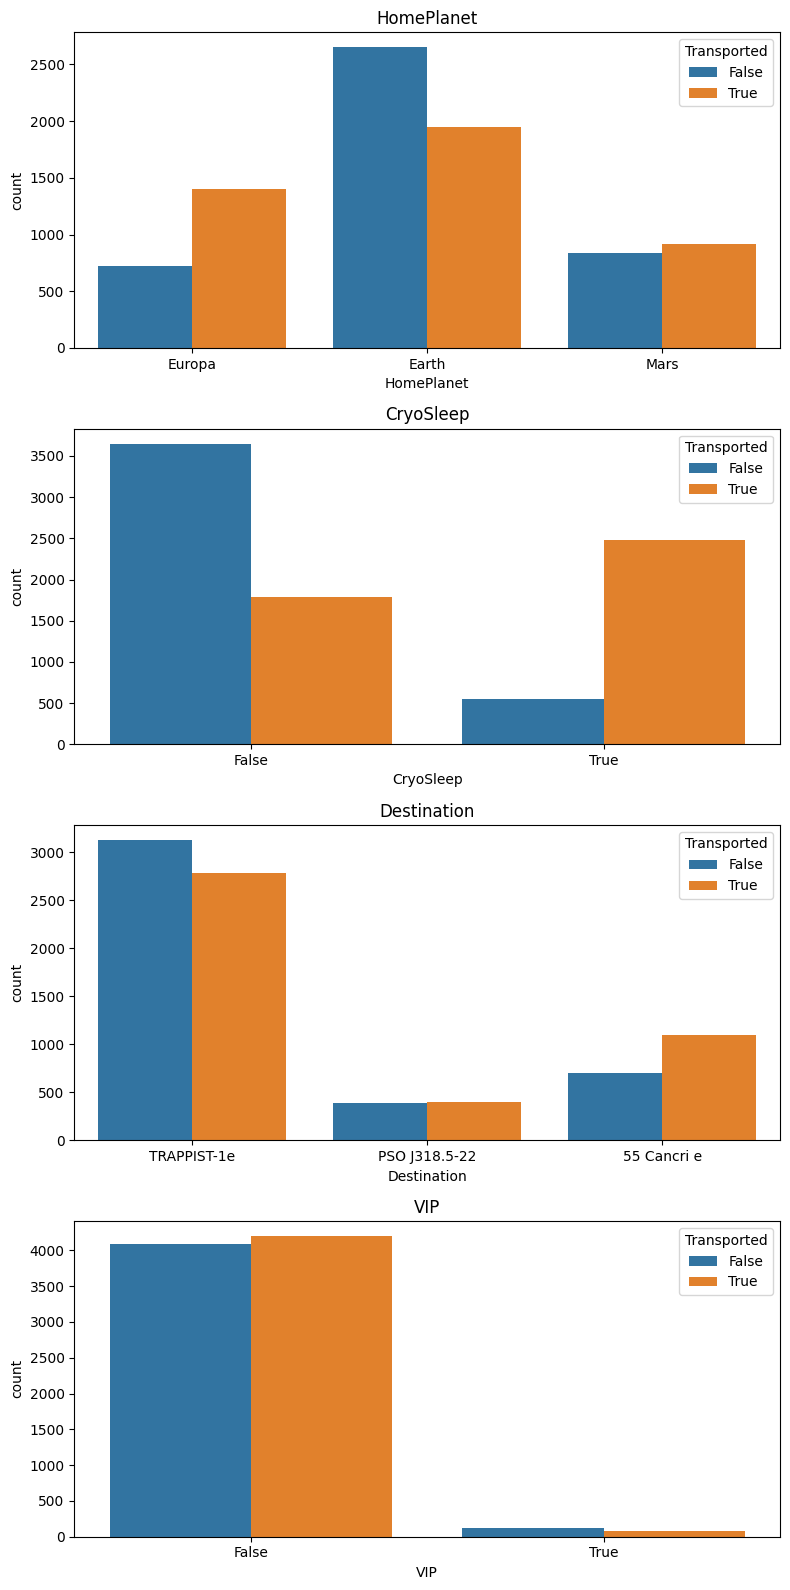

In [13]:
# categorical features
cat_feats=["HomePlanet","CryoSleep","Destination","VIP"]

# plot categorical features
fig=plt.figure(figsize=(8,16))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=df, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

# Feature Engineering

In [14]:
# make a copy of dataset
abt_2 = df.copy()
abt_2.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Passenger group

### Add Group, Solo and Group_size

In [15]:
def passenger_id_new_features(df):
    # split the PassengerId and add Group column
    df['Group'] = df['PassengerId'].apply(lambda x: str(x).split('_')[0])
    df['Member'] = df['PassengerId'].apply(lambda x: str(x).split('_')[1])
    
    # add 'Group_size' and 'Signle_member' feature
    df['Group_size'] = df['Group'].map(lambda x: pd.concat([df['Group']]).value_counts()[x])
    df['Solo'] = (df['Group_size'] ==1)


    
    # drop the memeber
    df.drop('Member', axis=1, inplace=True)    

passenger_id_new_features(abt_2)
abt_2.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Group_size,Solo
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,1,True
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,1,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,2,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,2,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,1,True


### Visualizing Group_size features

/tmp/ipykernel_20/1108175540.py:4: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


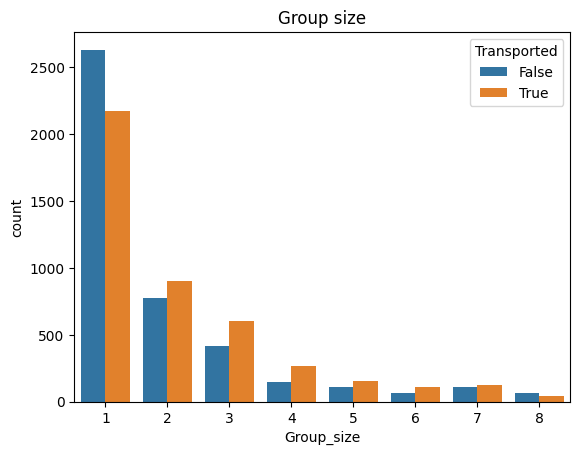

In [16]:
# Group_size distribution
sns.countplot(data=abt_2, x='Group_size', hue='Transported')
plt.title('Group size')
fig.tight_layout()

/tmp/ipykernel_20/48412546.py:4: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


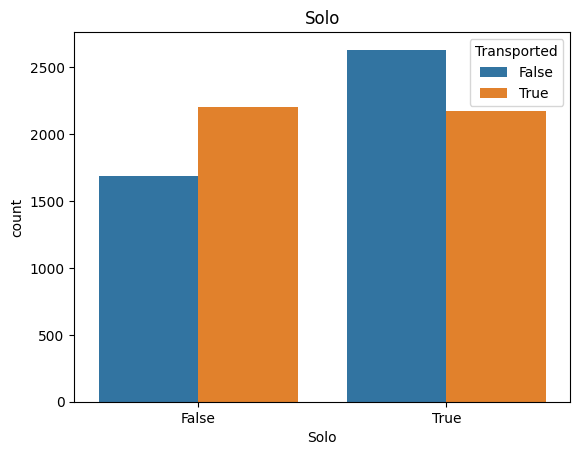

In [17]:
# Solo distribution
sns.countplot(data=abt_2, x='Solo', hue='Transported')
plt.title('Solo')
fig.tight_layout()

## Cabin

### Visualizing Cabin_deck & Cabin_side features

In [18]:
# Cabin - extract the deck and side to create new column Cabin_deck', 'Cabin_num' and 'Cabin_side'
def cabin_new_features(df):
    df['Cabin_deck'] = df['Cabin'].apply(lambda x: split_cabin_and_fill_missing(x)[0])
    df["Cabin_num"]  = df["Cabin"].apply(lambda x: split_cabin_and_fill_missing(x)[1])
    df['Cabin_side'] = df['Cabin'].apply(lambda x: split_cabin_and_fill_missing(x)[2])
    
    # replace"Missing" with NA
    df.loc[df['Cabin_deck']=='Missing','Cabin_deck']=np.nan
    df.loc[df['Cabin_num']=='Missing','Cabin_num']=np.nan
    df.loc[df['Cabin_side']=='Missing','Cabin_side']=np.nan
    
    df.drop('Cabin', axis = 1, inplace = True)

cabin_new_features(abt_2)
abt_2.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Group_size,Solo,Cabin_deck,Cabin_num,Cabin_side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,1,True,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,1,True,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,2,False,A,0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,2,False,A,0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,1,True,F,1,S


Text(0.5, 1.0, 'Cabin side')

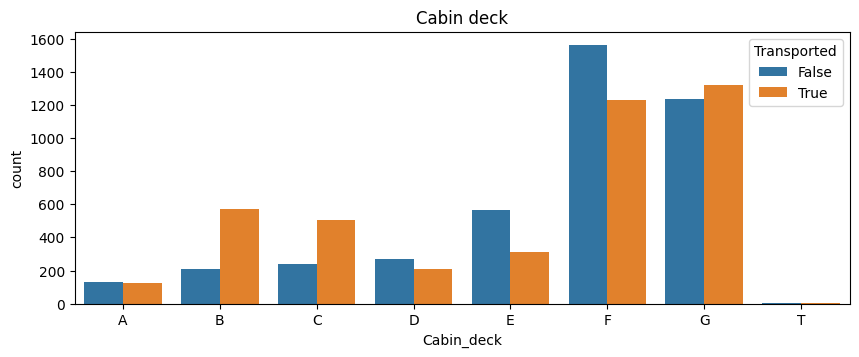

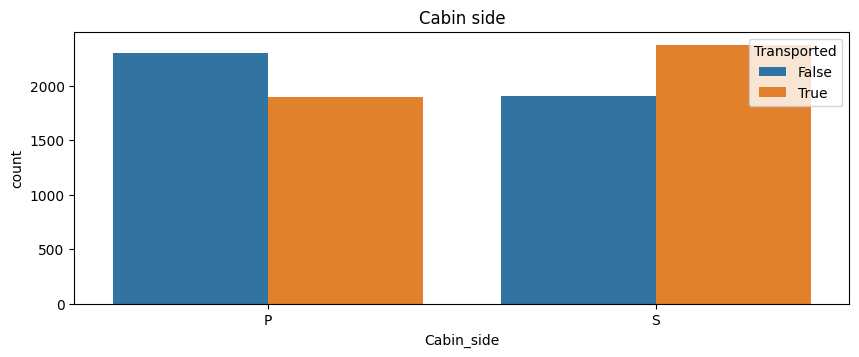

In [19]:
# categories in 'Cabin_deck'
cabin_deck_cat = abt_2['Cabin_deck'].loc[abt_2['Cabin_deck'].notna()].unique()
# 'Cabin_deck' distribution
fig=plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
sns.countplot(data=abt_2, x='Cabin_deck', hue='Transported', order=sorted(cabin_deck_cat))
plt.title('Cabin deck')

# categories in 'Cabin_side'
cabin_side_cat = abt_2['Cabin_side'].loc[abt_2['Cabin_side'].notna()].unique()
# 'Cabin_side' distribution
fig=plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
sns.countplot(data=abt_2, x='Cabin_side', hue='Transported', order=sorted(cabin_side_cat))
plt.title('Cabin side')

## Expenditure

### Add Total_expenditure and No_spending features

In [20]:
exp_cols = ["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]

def exp_new_features(df):
    df["Total_expenditure"] = df[exp_cols].sum(axis=1)
    df["No_spending"] = (df["Total_expenditure"]==0)
    
exp_new_features(abt_2)
abt_2.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Name,Transported,Group,Group_size,Solo,Cabin_deck,Cabin_num,Cabin_side,Total_expenditure,No_spending
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,Maham Ofracculy,False,0001,1,True,B,0,P,0.0,True
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,...,Juanna Vines,True,0002,1,True,F,0,S,736.0,False
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,...,Altark Susent,False,0003,2,False,A,0,S,10383.0,False
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,...,Solam Susent,False,0003,2,False,A,0,S,5176.0,False
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,...,Willy Santantines,True,0004,1,True,F,1,S,1091.0,False


### Visualizing Total_expenditure & No_spending features

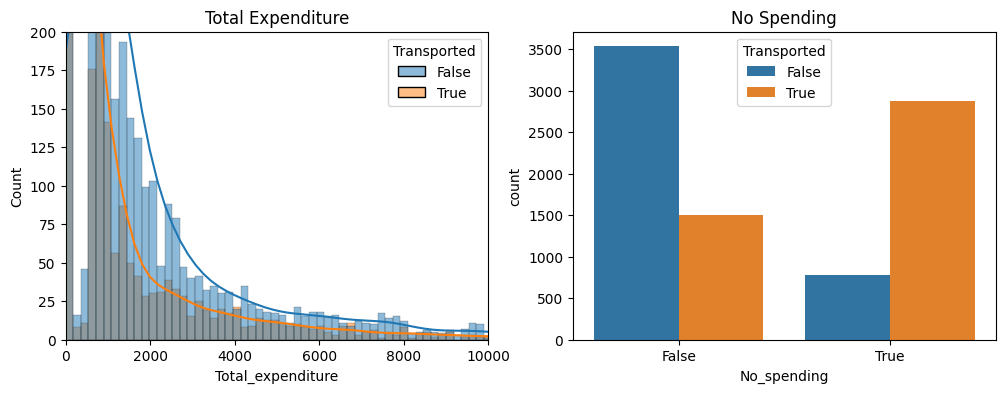

In [21]:
fig=plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(x="Total_expenditure", hue="Transported", data=abt_2, kde=True,bins=200)
plt.ylim(0,200)
plt.xlim(0,10000)
plt.title("Total Expenditure");

plt.subplot(1,2,2)
sns.countplot(x="No_spending", hue="Transported", data=abt_2)
plt.title("No Spending");

## Last name

### Add LastName and Family_size features

In [22]:
def name_new_features(df):
    # fill the missing name with "Missing"
    df['Name'].fillna('Missing', inplace=True)
    
    # split the last name
    if(len(df['Name'].str.split()[0]) == 2):
        df['LastName'] = df['Name'].apply(lambda x: str(x).split()[-1])
    
    # count how many family member
    df['Family_size'] = df['LastName'].map(lambda x: df['LastName'].value_counts()[x])
    
    # replace "Missing" with NA
    df.loc[df['Family_size'] == 200,'Family_size']=np.nan
    df.loc[df['LastName'] =='Missing','LastName']=np.nan
    
    # drop the Name column
    df.drop('Name', axis=1, inplace=True)

name_new_features(abt_2)
abt_2.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Group,Group_size,Solo,Cabin_deck,Cabin_num,Cabin_side,Total_expenditure,No_spending,LastName,Family_size
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,0001,1,True,B,0,P,0.0,True,Ofracculy,1.0
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,...,0002,1,True,F,0,S,736.0,False,Vines,4.0
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,...,0003,2,False,A,0,S,10383.0,False,Susent,6.0
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,...,0003,2,False,A,0,S,5176.0,False,Susent,6.0
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,...,0004,1,True,F,1,S,1091.0,False,Santantines,6.0


Text(0.5, 1.0, 'Family size')

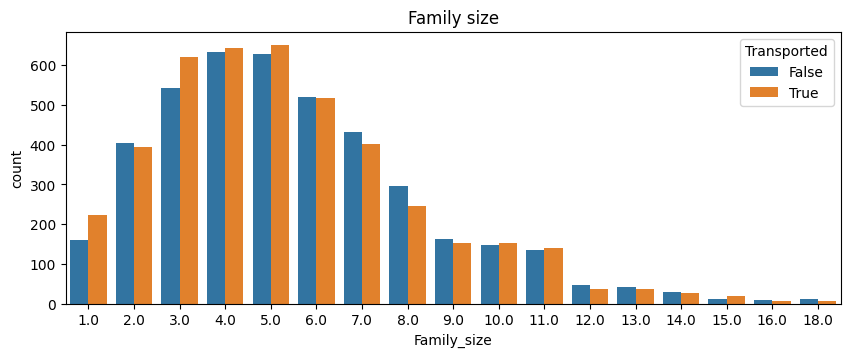

In [23]:
fig=plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
sns.countplot(data=abt_2, x='Family_size', hue='Transported')
plt.title('Family size')

## Age

### Add Age_group feature

In [24]:
def encode_age(age):
    # define age group of the passengers
    # children
    if age <= 12.0:
        return 'children 0-12'
    # teenagers
    elif 12.0 < age <= 18.0:
        return 'teenagers 13-18'
    # young adults
    elif 18.0 < age <= 25.0:
        return 'young_adults 19-25'
    # adults
    elif 25.0 < age <= 40.0:
        return 'adults 26-40'
    # middle age
    elif 40.0 < age <= 65.0:
        return 'middle_age 41-65'
    # eldery
    else:
        return 'eldery > 65'

def age_new_features(df):
    # encode the Age to Age_group
    df['Age_group'] = df['Age'].apply(encode_age)

age_new_features(abt_2)

Text(0.5, 1.0, 'Age_group')

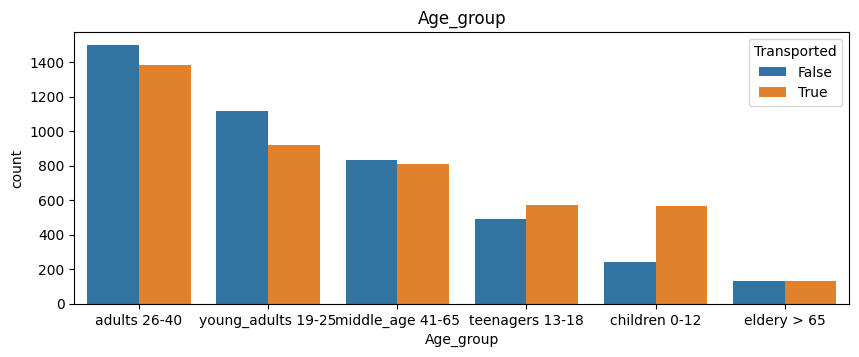

In [25]:
fig=plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
sns.countplot(data=abt_2, x='Age_group', hue='Transported')
plt.title('Age_group')

# Missing data

In [26]:
# missing column
na_cols = abt_2.columns[abt_2.isna().any()].tolist()

# # missing values summary
mv = pd.DataFrame(abt_2[na_cols].isna().sum(), columns=['Number_missing'])
mv['Percentage_missing']=np.round(100*mv['Number_missing']/len(abt_2),2)
mv

,Number_missing,Percentage_missing
HomePlanet,201,2.31
CryoSleep,217,2.50
Destination,182,2.09
Age,179,2.06
VIP,203,2.34
RoomService,181,2.08
FoodCourt,183,2.11
ShoppingMall,208,2.39
Spa,183,2.11
VRDeck,188,2.16


## Fill HomePlanet

### HomePlanet and LastName

In [27]:
LHP = abt_2.groupby('LastName')['HomePlanet'].nunique().reset_index(name='UniqueHomePlanetCount')

# count the number of LastName with only one unique HomePlanet
LHP_count = (LHP['UniqueHomePlanetCount'] == 1).sum()

print("The total number of LastName with the Homeplanet is not missing:", abt_2.loc[abt_2['HomePlanet'].notna(), 'LastName'].nunique())
print("Number of the same last name with only one unique HomePlanet:", LHP_count)

The total number of LastName with the Homeplanet is not missing: 2209
Number of the same last name with only one unique HomePlanet: 2209


In [28]:
print("Before - number of missing data in HomePlanet:", len(abt_2[abt_2['HomePlanet'].isna()]))
def fill_HomePlanet_by_LastName(df):
    # create a temporary DataFrame to hold the mappings
    mapping = df[['LastName', 'HomePlanet']].dropna().drop_duplicates()

    # fill missing values in HomePlanet based on LastName
    df['HomePlanet'] = df['LastName'].map(mapping.set_index('LastName')['HomePlanet']).combine_first(df['HomePlanet'])
fill_HomePlanet_by_LastName(abt_2)
print("After - number of missing data in HomePlanet fill by LastName:", len(abt_2[abt_2['HomePlanet'].isna()]))

Before - number of missing data in HomePlanet: 201
After - number of missing data in HomePlanet fill by LastName: 15


### HomePlanet and Cabin_deck

Text(0.5, 1.0, 'Cabin deck and HomePlanet')

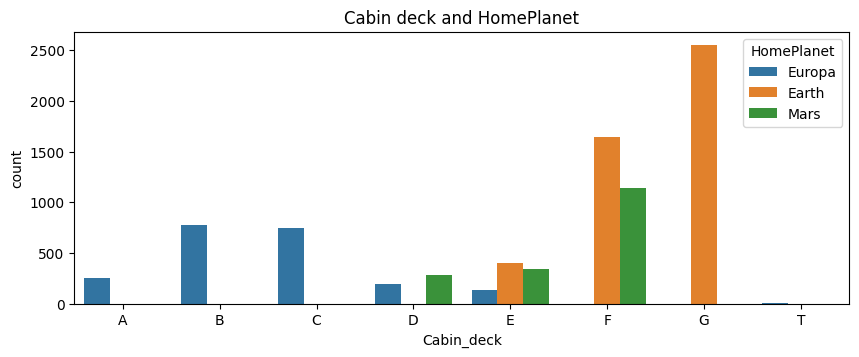

In [29]:
# categories in Cabin_deck
cabin_deck_cat = abt_2['Cabin_deck'].loc[abt_2['Cabin_deck'].notna()].unique()
# Cabin_deck distribution
fig=plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
sns.countplot(data=abt_2, x='Cabin_deck', hue='HomePlanet', order=sorted(cabin_deck_cat))
plt.title('Cabin deck and HomePlanet')

In [30]:
print("Before - number of missing data in HomePlanet: ", len(abt_2[abt_2['HomePlanet'].isna()]))

def fill_HomePlanet_by_Cabin_deck(df):
    # Cabin_deck is A, B, C, T fill Europa in HomePlanet
    df.loc[(df['Cabin_deck'].isin(['A', 'B', 'C', 'T'])) & (df['HomePlanet'].isna()), 'HomePlanet'] = 'Europa'
    # Cabin_deck is G fill Earth in HomePlanet
    df.loc[(df['Cabin_deck'] == 'G') & (df['HomePlanet'].isna()), 'HomePlanet'] = 'Earth'
        
fill_HomePlanet_by_Cabin_deck(abt_2)
print("After - number of missing data in HomePlanet filled by Cabin_deck:", len(abt_2[abt_2['HomePlanet'].isna()]))

Before - number of missing data in HomePlanet:  15
After - number of missing data in HomePlanet filled by Cabin_deck: 10


### HomePlanet and Destination

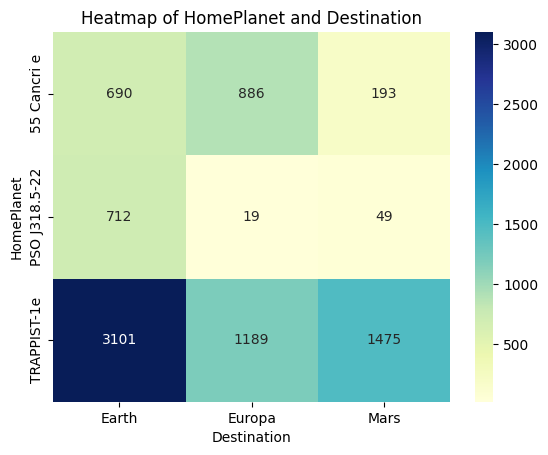

In [31]:
# calculate the count of occurrences for each combination of HomePlanet and Destination
heatmap_data = df.groupby(['Destination', 'HomePlanet']).size().unstack(fill_value=0)

# create the heatmap
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='d')

# add labels and title
plt.xlabel('Destination')
plt.ylabel('HomePlanet')
plt.title('Heatmap of HomePlanet and Destination')

# display the plot
plt.show()

In [32]:
print("Before - number of missing data in HomePlanet:", len(abt_2[abt_2['HomePlanet'].isna()]))
def fill_HomePlanet_by_Destination(df):
    # fill the NA HomePlanet values with Earth when Destination is TRAPPIST-1e and cabin_deck is not 'D'
    df.loc[(df['Destination'] == 'TRAPPIST-1e') & (df['HomePlanet'].isna()) & (df['Cabin_deck'] != 'D'), 'HomePlanet'] = 'Earth'
    df.loc[(df['Destination'] == 'TRAPPIST-1e') & (df['HomePlanet'].isna()) & (df['Cabin_deck'] == 'D'), 'HomePlanet'] = 'Mars'
    
fill_HomePlanet_by_Destination(abt_2)
print("After - number of missing data in HomePlanet filled by Destination:", len(abt_2[abt_2['HomePlanet'].isna()]))

Before - number of missing data in HomePlanet: 10
After - number of missing data in HomePlanet filled by Destination: 1


### HomePlanet and Group

In [33]:
GHP = abt_2.groupby('Group')['HomePlanet'].nunique().reset_index(name='UniqueHomePlanetCount')

# count the number of Group with only one unique HomePlanet
GHP_count = (GHP['UniqueHomePlanetCount'] == 1).sum()

print("The total number of Groups with the Homeplanet is not missing:", abt_2.loc[abt_2['HomePlanet'].notna(), 'Group'].nunique())
print("Number of Goup with only one unique HomePlanet:", GHP_count)

The total number of Groups with the Homeplanet is not missing: 6217
Number of Goup with only one unique HomePlanet: 6216


In [34]:
print("Before - number of missing data in HomePlanet:", len(abt_2[abt_2['HomePlanet'].isna()]))
def fill_HomePlanet_Group(df):
    df['HomePlanet'] = df.groupby('Group')['HomePlanet'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

fill_HomePlanet_Group(abt_2)
print("After - number of missing data in HomePlanet filled by Group:", len(abt_2[abt_2['HomePlanet'].isna()]))

Before - number of missing data in HomePlanet: 1
After - number of missing data in HomePlanet filled by Group: 0


## Fill CrypoSleep

### CrypoSleep and No_spending

Text(0.5, 1.0, 'CryoSleep and NoSpending')

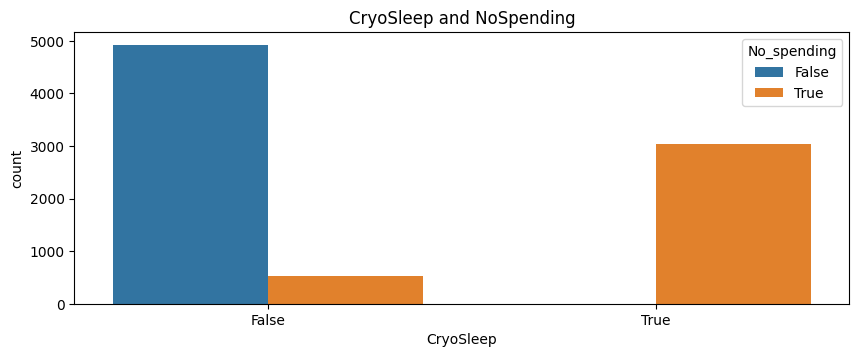

In [35]:
fig=plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
sns.countplot(data=abt_2, x='CryoSleep', hue='No_spending')
plt.title('CryoSleep and NoSpending')

In [36]:
print("Before - number of missing data in CryoSleep:", len(abt_2[abt_2['CryoSleep'].isna()]))
def fill_CryoSleep_by_NoSpending(df):
    # passengers who are no spending fill CryoSleep with True
    df.loc[(df['No_spending'] == True) & (df['CryoSleep'].isna()), 'CryoSleep'] = True
    # passengers who are spending fill CryoSleep with False
    df.loc[(df['No_spending'] == False) & (df['CryoSleep'].isna()), 'CryoSleep'] = False

fill_CryoSleep_by_NoSpending(abt_2)
print("After - number of missing data in CryoSleep:", len(abt_2[abt_2['CryoSleep'].isna()]))

Before - number of missing data in CryoSleep: 217
After - number of missing data in CryoSleep: 0


## Fill Destination

In [37]:
print("Before - number of missing data in Destination:", len(abt_2[abt_2['Destination'].isna()]))
def fill_Destination(df):
    df['Destination'].fillna('TRAPPIST-1e', inplace=True)

fill_Destination(abt_2)
print("After - number of missing data in Destination:", len(abt_2[abt_2['Destination'].isna()]))

Before - number of missing data in Destination: 182
After - number of missing data in Destination: 0


## Fill LastName

### LastName and Group

In [38]:
GLN = abt_2.groupby('Group')['LastName'].nunique().reset_index(name='GroupWithUniqueLastName')

# count the number of Group with unique LastName
GLN_count = (GLN['GroupWithUniqueLastName'] == 1).sum()

print("Total number of group:", len(abt_2['Group'].unique()))
print("Number of Group with only one unique LastName:", GLN_count)

Total number of group: 6217
Number of Group with only one unique LastName: 5864


In [39]:
print("Before - number of missing data in LastName:", len(abt_2[abt_2['LastName'].isna()]))
def fill_LastName(df):
    # fill missing data with ‘Missing’
    df['LastName'].fillna('Missing', inplace=True)

fill_LastName(abt_2)
print("Before - number of missing data in LastName:", len(abt_2[abt_2['LastName'].isna()]))

Before - number of missing data in LastName: 200
Before - number of missing data in LastName: 0


## Fill VIP

### VIP, HomePlanet, Destination and Age_group

In [40]:
abt_2.groupby(['HomePlanet', 'Age_group', 'Destination', 'VIP'])['VIP'].size().unstack().fillna(0)

VIP                                          False  True 
HomePlanet Age_group          Destination                
Earth      adults 26-40       55 Cancri e    150.0    0.0
                              PSO J318.5-22  177.0    0.0
                              TRAPPIST-1e    863.0    0.0
           children 0-12      55 Cancri e    131.0    0.0
                              PSO J318.5-22   54.0    0.0
                              TRAPPIST-1e    383.0    0.0
           eldery > 65        55 Cancri e     11.0    0.0
                              PSO J318.5-22   16.0    0.0
                              TRAPPIST-1e     91.0    0.0
           middle_age 41-65   55 Cancri e     86.0    0.0
                              PSO J318.5-22  106.0    0.0
                              TRAPPIST-1e    501.0    0.0
           teenagers 13-18    55 Cancri e    124.0    0.0
                              PSO J318.5-22  129.0    0.0
                              TRAPPIST-1e    449.0    0.0
           young_adults 19-25 55 Cancri e    176.0    0.0
                              PSO J318.5-22  224.0    0.0
                              TRAPPIST-1e    927.0    0.0
Europa     adults 26-40       55 Cancri e    372.0   40.0
                              PSO J318.5-22    8.0    6.0
                              TRAPPIST-1e    549.0   36.0
           children 0-12      55 Cancri e      9.0    0.0
                              TRAPPIST-1e     34.0    0.0
           eldery > 65        55 Cancri e     32.0    1.0
                              TRAPPIST-1e     39.0    3.0
           middle_age 41-65   55 Cancri e    215.0   23.0
                              PSO J318.5-22    1.0    3.0
                              TRAPPIST-1e    316.0   15.0
           teenagers 13-18    55 Cancri e     65.0    0.0
                              TRAPPIST-1e     91.0    0.0
           young_adults 19-25 55 Cancri e    130.0    1.0
                              PSO J318.5-22    0.0    1.0
                              TRAPPIST-1e    138.0    4.0
Mars       adults 26-40       55 Cancri e     54.0    0.0
                              PSO J318.5-22   20.0    7.0
                              TRAPPIST-1e    513.0   34.0
           children 0-12      55 Cancri e     22.0    0.0
                              TRAPPIST-1e    149.0    0.0
           eldery > 65        55 Cancri e      6.0    0.0
                              PSO J318.5-22    3.0    0.0
                              TRAPPIST-1e     52.0    3.0
           middle_age 41-65   55 Cancri e     31.0    0.0
                              PSO J318.5-22   11.0    0.0
                              TRAPPIST-1e    285.0   15.0
           teenagers 13-18    55 Cancri e     22.0    0.0
                              PSO J318.5-22    3.0    0.0
                              TRAPPIST-1e    148.0    1.0
           young_adults 19-25 55 Cancri e     56.0    0.0
                              PSO J318.5-22    4.0    1.0
                              TRAPPIST-1e    315.0    5.0

In [41]:
print("Before - number of missing data in VIP:", len(abt_2[abt_2['VIP'].isna()]))
def fill_VIP_with_Age_and_Destination(df):
    df.loc[(df['VIP'].isna() & (df['Age'] <= 18)), 'VIP'] = False
    # fill False to passengers from Earth
    df.loc[(df['VIP'].isna() & (df['HomePlanet'] == 'Earth')), 'VIP'] = False
    # fill False to passengers from Mars and Destination is 55 Cancri e
    df.loc[(df['VIP'].isna() & (df['HomePlanet'] == 'Mars') & (df['Destination'] == '55 Cancri e')), 'VIP'] = False

fill_VIP_with_Age_and_Destination(abt_2)
print("After - number of missing data in VIP:", len(abt_2[abt_2['VIP'].isna()]))

Before - number of missing data in VIP: 203
After - number of missing data in VIP: 71


### Remaining missing VIP

In [42]:
print("Before - number of missing data in VIP:", len(abt_2[abt_2['VIP'].isna()]))
def fill_VIP_missing(df):
    df['VIP'].fillna(False, inplace=True)

fill_VIP_missing(abt_2)
print("After - number of missing data in VIP:", len(abt_2[abt_2['VIP'].isna()]))

Before - number of missing data in VIP: 71
After - number of missing data in VIP: 0


## Fill Cabin_side

### Cabin_side and Group

In [43]:
GCS = abt_2.groupby('Group')['Cabin_side'].nunique().reset_index(name='UniqueCabin_side')

# Count the number of Group with only one unique Cabin_side
GCS_count = (GCS['UniqueCabin_side'] == 1).sum()

print("The total number of Group with the Cabin_side is not missing:", abt_2.loc[abt_2['Cabin_side'].notna(), 'Group'].nunique())
print("Number of the same last name with the same Cabin_side:", GCS_count)

The total number of Group with the Cabin_side is not missing: 6118
Number of the same last name with the same Cabin_side: 6118


In [44]:
print("Before - number of missing data in Cabin_side:", len(abt_2[abt_2['Cabin_side'].isna()]))
def fill_Cabin_side_Group(df):
    df['Cabin_side'] = df.groupby('Group')['Cabin_side'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

fill_Cabin_side_Group(abt_2)
print("After - number of missing data in Cabin_side filled by Group:", len(abt_2[abt_2['Cabin_side'].isna()]))

Before - number of missing data in Cabin_side: 199
After - number of missing data in Cabin_side filled by Group: 99


### Remaining missing Cabin_side

In [45]:
print("Before - number of missing data in Cabin_side:", len(abt_2[abt_2['Cabin_side'].isna()]))
def fill_Cabin_side_missing(df):
    df['Cabin_side'] = df['Cabin_side'].fillna(pd.Series(np.random.choice(['P', 'S'], size=len(df), p=[0.5, 0.5])))
    
fill_Cabin_side_missing(abt_2)
print("After - number of missing data in Cabin_side:", len(abt_2[abt_2['Cabin_side'].isna()]))

Before - number of missing data in Cabin_side: 99
After - number of missing data in Cabin_side: 0


## Fill Cabin_deck

### Cabin_deck and HomePlanet

Text(0.5, 1.0, 'Cabin deck and HomePlanet')

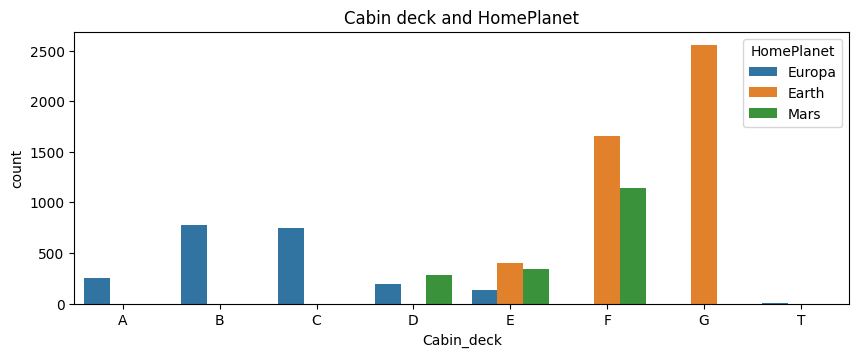

In [46]:
# categories in 'Cabin_deck'
cabin_deck_cat = abt_2['Cabin_deck'].loc[abt_2['Cabin_deck'].notna()].unique()
# 'Cabin_deck' distribution
fig=plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
sns.countplot(data=abt_2, x='Cabin_deck', hue='HomePlanet', order=sorted(cabin_deck_cat))
plt.title('Cabin deck and HomePlanet')

In [47]:
print("Before - number of missing data in HomePlanet: ", len(abt_2[abt_2['Cabin_deck'].isna()]))

def fill_Cabin_deck_by_HomePlanet(df):
    # HomePlanet is Earth fill 'G'
    df.loc[(df['Cabin_deck'].isna()) & (df['HomePlanet'] == 'Earth'), 'Cabin_deck'] = 'G'
    # HomePlanet is Earth fill 'G'
    df.loc[(df['Cabin_deck'].isna()) & (df['HomePlanet'] == 'Mars'), 'Cabin_deck'] = 'F'
        
fill_Cabin_deck_by_HomePlanet(abt_2)
print("After - number of missing data in Cabin_deck filled by HomePlanet:", len(abt_2[abt_2['Cabin_deck'].isna()]))

Before - number of missing data in HomePlanet:  199
After - number of missing data in Cabin_deck filled by HomePlanet: 62


### Remaining missing Cabin_deck

In [48]:
print("Before - number of missing data in Cabin_deck:", len(abt_2[abt_2['Cabin_deck'].isna()]))
def fill_Cabin_deck_missing(df):
    df['Cabin_deck'].fillna('Missing', inplace=True)
    
fill_Cabin_deck_missing(abt_2)
print("After - number of missing data in Cabin_deck:", len(abt_2[abt_2['Cabin_deck'].isna()]))

Before - number of missing data in Cabin_deck: 62
After - number of missing data in Cabin_deck: 0


## Fill Cabin_num

In [49]:
print('Number of unique Cabin_num:', abt_2['Cabin_num'].nunique())
print("Before - number of missing data in Cabin_num:", len(abt_2[abt_2['Cabin_num'].isna()]))
def fill_Cabin_num_missing(df):
    df['Cabin_num'].fillna('Missing', inplace=True)

fill_Cabin_num_missing(abt_2)
print("After - number of missing data in Cabin_num:", len(abt_2[abt_2['Cabin_num'].isna()]))

Number of unique Cabin_num: 1817
Before - number of missing data in Cabin_num: 199
After - number of missing data in Cabin_num: 0


## Fill Age

### Age, No_spending and VIP

In [50]:
abt_2.groupby(['Age_group', 'No_spending', 'VIP'])['Age_group'].size().unstack().fillna(0)

VIP                              False  True 
Age_group          No_spending               
adults 26-40       False        1772.0  104.0
                   True          992.0   19.0
children 0-12      True          806.0    0.0
eldery > 65        False         140.0    5.0
                   True          116.0    2.0
middle_age 41-65   False        1025.0   51.0
                   True          566.0    5.0
teenagers 13-18    False         569.0    1.0
                   True          489.0    0.0
young_adults 19-25 False        1363.0   10.0
                   True          656.0    2.0

In [51]:
# Age - fill missing data the mean of the age
print("Before - number of missing data in Age:", len(abt_2[abt_2['Age'].isna()]))
def fill_age(df):
    # median Age for people with VIP status
    df.loc[((df['VIP'] == True) & df['Age'].isna()), 'Age'] = df.loc[(df['VIP'] == True), 'Age'].median()

    # median Age for people that have expenses
    df.loc[(df['Age'].isna() & (df['No_spending'] == False)), 'Age'] = df.loc[df['No_spending'] == False, 'Age'].median()

    # median Age for people with no expenses and not in CryoSleep
    df.loc[(df['Age'].isna() & (df['No_spending'] == True) & (df['CryoSleep'] == False)), 'Age'] = df.loc[(df['No_spending'] == True) & (df['CryoSleep'] == False), 'Age'].median()

    age_median = df["Age"].median()
    df['Age'].fillna(age_median, inplace=True)
    
fill_age(abt_2)
print("After - number of missing data in Age:", len(abt_2[abt_2['Age'].isna()]))

Before - number of missing data in Age: 179
After - number of missing data in Age: 0


## Fill Expenditure

### Expenditure and CryoSleep

In [52]:
exp_feats = ["RoomService","FoodCourt", "Spa", "ShoppingMall","VRDeck"]
print("Before - number of missing data in expenditure:", abt_2[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].isna().sum())

# Age - fill missing data the mean of the age
def fill_expenditure_with_CryoSleep(df):
    for col in exp_feats:
        df.loc[(df[col].isna()) & (df['CryoSleep'] == True), col] = 0
    
fill_expenditure_with_CryoSleep(abt_2)
print("After - number of missing data in expenditure:", abt_2[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].isna().sum())

Before - number of missing data in expenditure: RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
dtype: int64
After - number of missing data in expenditure: RoomService     113
FoodCourt       112
ShoppingMall    109
Spa             116
VRDeck          121
dtype: int64


In [53]:
print("Before - number of missing data in expenditure:", abt_2[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].isna().sum())
def fill_expenditure_missing(df):
    # RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
    # most of the distribution is 0, so just fill 0 for the missing data
    df['RoomService'].fillna(0, inplace=True)
    df['FoodCourt'].fillna(0, inplace=True)
    df['ShoppingMall'].fillna(0, inplace=True)
    df['Spa'].fillna(0, inplace=True)
    df['VRDeck'].fillna(0, inplace=True)
    
fill_expenditure_missing(abt_2)
print("After - number of missing data in expenditure:", abt_2[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].isna().sum())    

Before - number of missing data in expenditure: RoomService     113
FoodCourt       112
ShoppingMall    109
Spa             116
VRDeck          121
dtype: int64
After - number of missing data in expenditure: RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64


### Update the Total_expenditure and No_spending

In [54]:
df['Total_expenditure'] = df[exp_feats].sum(axis=1)
df['No_spending'] = (df['Total_expenditure'] == 0)

## Family_size

In [55]:
print("Before - number of missing data in Family_size:", len(abt_2[abt_2['Family_size'].isna()]))
def fill_family_size(df):
    df['Family_size'] = df['LastName'].map(lambda x: df['LastName'].value_counts()[x])
    df['Family_size'].fillna(0, inplace = True)

fill_family_size(abt_2)
print("After - number of missing data in Family_size:", len(abt_2[abt_2['Family_size'].isna()]))

Before - number of missing data in Family_size: 200
After - number of missing data in Family_size: 0


# Preprocessing dataset 2

In [56]:
abt_2.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Group_size,Solo,Cabin_deck,Cabin_num,Cabin_side,Total_expenditure,No_spending,LastName,Family_size,Age_group
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,1,True,B,0,P,0.0,True,Ofracculy,1,adults 26-40
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,...,1,True,F,0,S,736.0,False,Vines,4,young_adults 19-25
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,...,2,False,A,0,S,10383.0,False,Susent,6,middle_age 41-65
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,...,2,False,A,0,S,5176.0,False,Susent,6,adults 26-40
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,...,1,True,F,1,S,1091.0,False,Santantines,6,teenagers 13-18


In [57]:
# drop the high cardinality features
def drop_high_cardinality(df):
    df.drop('Cabin_num', axis=1, inplace=True)
    df.drop('LastName', axis=1, inplace=True)
    df.drop('Group', axis=1, inplace=True)
    
drop_high_cardinality(abt_2)

# Modeling

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [59]:
# Create the features columns
# drop the identifier columns
X = abt_2.drop(["Transported", "PassengerId"], axis=1)
# One-hot encoding
X = pd.get_dummies(X, dtype=int)
# Create the label column
y = abt_2["Transported"]

In [60]:
# split the training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1005)

In [61]:
X_train.head()

,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group_size,Solo,Total_expenditure,...,Cabin_deck_Missing,Cabin_deck_T,Cabin_side_P,Cabin_side_S,Age_group_adults 26-40,Age_group_children 0-12,Age_group_eldery > 65,Age_group_middle_age 41-65,Age_group_teenagers 13-18,Age_group_young_adults 19-25
5559,32.0,False,0.0,0.0,0.0,241.0,4757.0,3,False,4998.0,...,0,0,0,1,1,0,0,0,0,0
2765,20.0,False,0.0,0.0,585.0,0.0,10.0,1,True,595.0,...,0,0,0,1,0,0,0,0,0,1
3035,21.0,False,0.0,0.0,0.0,646.0,138.0,4,False,784.0,...,0,0,0,1,0,0,0,0,0,1
5544,5.0,False,0.0,0.0,0.0,0.0,0.0,3,False,0.0,...,0,0,0,1,0,1,0,0,0,0
7747,40.0,False,0.0,0.0,0.0,0.0,0.0,2,False,0.0,...,0,0,0,1,1,0,0,0,0,0


# Setup machine learning pipelines

In [62]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
import time

In [63]:
# StandardScaler - z = (x - u) / s 
classifiers = {
    'RandomForest': make_pipeline(StandardScaler(), RandomForestClassifier(random_state=1005)),
    "LGBM" : make_pipeline(StandardScaler(), LGBMClassifier(random_state=1005)),
}

In [64]:
grid = {
    'RandomForest': {
        'randomforestclassifier__n_estimators':[50, 100, 150, 200, 250, 300],
        'randomforestclassifier__max_depth': [4, 6, 8, 10, 12],
    },
    'LGBM': {
        'lgbmclassifier__n_estimators': [50, 100, 150, 200],
        'lgbmclassifier__max_depth': [4, 8, 12],
        'lgbmclassifier__learning_rate': [0.05, 0.1, 0.15],
    },    
}

In [65]:
fit_models = {}

valid_scores = pd.DataFrame({'Classifer':classifiers.keys(), 'Validation accuracy': np.zeros(len(classifiers)), 'Training time': np.zeros(len(classifiers))})
# loop all the classifiers
for algo, classifier in classifiers.items():
    start_time = time.time()
    print(f'Training the {algo} model')
    # create grid search CV
    clf = GridSearchCV(estimator=classifier, param_grid=grid[algo], n_jobs=-1, cv=None)
    # train the model
    clf.fit(X_train, y_train)
    
    end_time = time.time()
    
    # store the trained result
    fit_models[algo] = clf
    
    training_time = end_time - start_time
    print('Training time (second):', training_time)

Training the RandomForest model
Training time (second): 62.63286113739014
Training the LGBM model
Training time (second): 58.94967818260193


In [66]:
fit_models

{'RandomForest': GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                        ('randomforestclassifier',
                                         RandomForestClassifier(random_state=1005))]),
              n_jobs=-1,
              param_grid={'randomforestclassifier__max_depth': [4, 6, 8, 10, 12],
                          'randomforestclassifier__n_estimators': [50, 100, 150,
                                                                   200, 250,
                                                                   300]}),
 'LGBM': GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                        ('lgbmclassifier',
                                         LGBMClassifier(random_state=1005))]),
              n_jobs=-1,
              param_grid={'lgbmclassifier__learning_rate': [0.05, 0.1, 0.15],
                          'lgbmclassifier__max_depth': [4, 8, 12],
                  

# Evaluate the performance

In [67]:
from sklearn.metrics import accuracy_score

In [68]:
for algo, classifier in fit_models.items():
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Model: {algo}')
    print(f'Accuracy score: {accuracy}')

Model: RandomForest
Accuracy score: 0.807898773006135
Model: LGBM
Accuracy score: 0.8094325153374233


# Predict on Test Data

In [69]:
# read the test.csv
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
# make a copy of test_df
abt_test = test_df.copy()

# for dataset 1
# preprocessing(abt_test)

passenger_id_new_features(abt_test)
cabin_new_features(abt_test)
exp_new_features(abt_test)
name_new_features(abt_test)
age_new_features(abt_test)
fill_HomePlanet_by_LastName(abt_test)
fill_HomePlanet_by_Cabin_deck(abt_test)
fill_HomePlanet_by_Destination(abt_test)
fill_HomePlanet_Group(abt_test)
fill_CryoSleep_by_NoSpending(abt_test)
fill_Destination(abt_test)
fill_LastName(abt_test)
fill_VIP_with_Age_and_Destination(abt_test)
fill_VIP_missing(abt_test)
fill_Cabin_side_Group(abt_test)
fill_Cabin_side_missing(abt_test)
fill_Cabin_deck_by_HomePlanet(abt_test)
fill_Cabin_deck_missing(abt_test)
fill_Cabin_num_missing(abt_test)
fill_age(abt_test)
fill_expenditure_with_CryoSleep(abt_test)
fill_expenditure_missing(abt_test)
fill_family_size(abt_test)
drop_high_cardinality(abt_test)

# one-hot encoding
abt_test = pd.get_dummies(abt_test.drop('PassengerId', axis=1), dtype=int)

In [70]:
y_pred = fit_models['LGBM'].predict(abt_test)

# Submission

In [71]:
submission = pd.DataFrame([test_df['PassengerId'], y_pred]).T
submission.columns = ['PassengerID', 'Transported']
submission.to_csv('submission.csv', index=False)